In [1]:
!pip install lightgbm shap plotly --quiet


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lightgbm as lgb
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


In [3]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/3ae033f50fa345051652.csv"
df = pd.read_csv(file_path)  # Replace with your actual filename
print(df.head())
print(df.info())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                Date          County State Vehicle Primary Use  \
0  September 30 2022       Riverside    CA           Passenger   
1   December 31 2022  Prince William    VA           Passenger   
2    January 31 2020          Dakota    MN           Passenger   
3       June 30 2022           Ferry    WA               Truck   
4       July 31 2021         Douglas    CO           Passenger   

  Battery Electric Vehicles (BEVs) Plug-In Hybrid Electric Vehicles (PHEVs)  \
0                                7                                        0   
1                                1                                        2   
2                                0                                        1   
3                                0                                        0   
4                                0                                        1   


In [4]:
df = df.dropna()

# Identify and clean numeric columns that might contain commas or other non-numeric characters
numeric_cols = ['Battery Electric Vehicles (BEVs)', 'Plug-In Hybrid Electric Vehicles (PHEVs)', 'Electric Vehicle (EV) Total', 'Non-Electric Vehicle Total', 'Total Vehicles']
for col in numeric_cols:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False)
    # Use errors='coerce' to turn any values that cannot be converted into NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check for rows with NaN values introduced by coercion and display them
nan_rows = df[df[numeric_cols].isnull().any(axis=1)]
if not nan_rows.empty:
    print("Rows with non-numeric values after cleaning:")
    display(nan_rows)
else:
    print("No non-numeric values found in specified columns after cleaning.")

# Drop rows where conversion failed for the numeric columns
df.dropna(subset=numeric_cols, inplace=True)


df['Date'] = pd.to_datetime(df['Date']) # Convert 'Date' column to datetime objects
df['Year'] = df['Date'].dt.year # Extract the year into a new 'Year' column
df = df.sort_values('Date') # Sort by Date
df.set_index('Date', inplace=True) # Set Date as the index


X = df.drop(['Percent Electric Vehicles', 'Year'], axis=1) # Drop the target and Year column
y = df['Percent Electric Vehicles'] # Set 'Percent Electric Vehicles' as the target

No non-numeric values found in specified columns after cleaning.


/tmp/ipython-input-3579676522.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str).str.replace(',', '', regex=False)
/tmp/ipython-input-3579676522.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')
/tmp/ipython-input-3579676522.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [5]:
# One-hot encode categorical features
X = pd.get_dummies(X, columns=['County', 'State', 'Vehicle Primary Use'], drop_first=True)
print(X.head())
print(X.info())

            Battery Electric Vehicles (BEVs)  \
Date                                           
2017-01-31                                 1   
2017-01-31                                 1   
2017-01-31                                 0   
2017-01-31                               129   
2017-01-31                                 1   

            Plug-In Hybrid Electric Vehicles (PHEVs)  \
Date                                                   
2017-01-31                                         0   
2017-01-31                                         0   
2017-01-31                                         0   
2017-01-31                                       129   
2017-01-31                                         0   

            Electric Vehicle (EV) Total  Non-Electric Vehicle Total  \
Date                                                                  
2017-01-31                            1                          46   
2017-01-31                            1                  

In [6]:
future_X = pd.DataFrame({col: [X[col].mean()]*2 for col in X.columns})
future_years = pd.to_datetime(['2025', '2026'])


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [8]:
models = {
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1),
    'RandomForest': RandomForestRegressor(n_estimators=100),
    'LinearRegression': LinearRegression()
}

results = {}

for name, m in models.items():
    m.fit(X_train, y_train)
    pred = m.predict(X_test)
    results[name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test, pred)),
        'MAE': mean_absolute_error(y_test, pred),
        'R2': r2_score(y_test, pred)
    }

comparison_df = pd.DataFrame(results).T
print("📊 Model Comparison:\n")
display(comparison_df.sort_values('RMSE'))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 16586, number of used features: 283
[LightGBM] [Info] Start training from score 3.850360
📊 Model Comparison:



,RMSE,MAE,R2
RandomForest,0.478978,0.115682,0.998453
LightGBM,0.640380,0.154767,0.997235
LinearRegression,6.957595,2.758881,0.673583


100%|===================| 20726/20733 [09:52<00:00]       

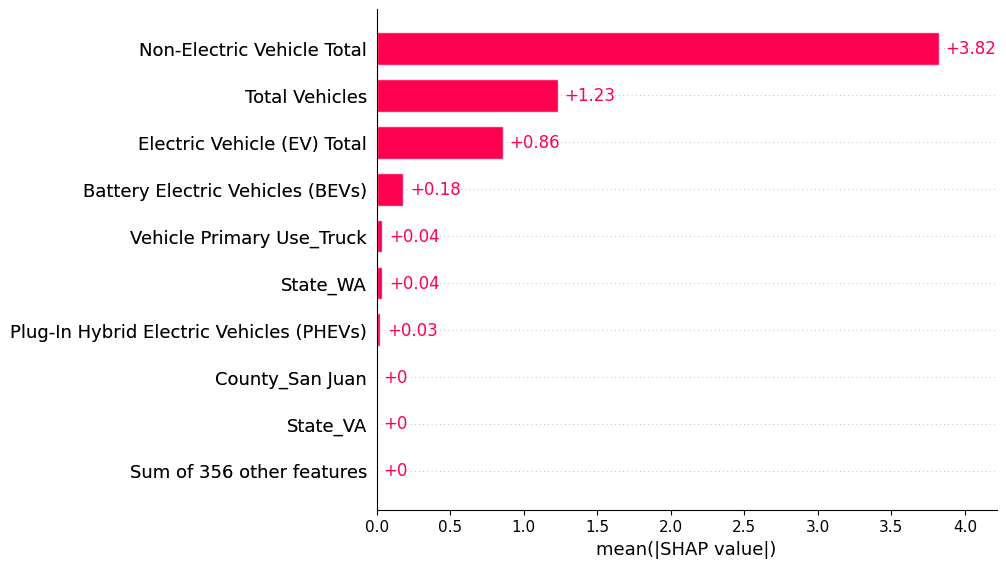

In [13]:
# ✅ SHAP-based Model Explanation (Safe Version)
# !pip install shap xgboost --quiet # Already installed

import shap
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pandas as pd # Import pandas if not already imported in this cell
import numpy as np # Import numpy

# Step 1: Get best model name from comparison_df
best_model_name = comparison_df.sort_values(by='RMSE').index[0]
best_model = models[best_model_name]

# Step 2: Prepare data for SHAP
X_clean = X.copy()

# Convert all columns to numeric, coercing errors to NaN
for col in X_clean.columns:
    X_clean[col] = pd.to_numeric(X_clean[col], errors='coerce')

# Drop columns that could not be converted to numeric
X_clean.dropna(axis=1, inplace=True)

# Drop rows with NaNs that might have been introduced by coercion
X_clean.dropna(inplace=True)

# Convert the DataFrame to a NumPy array of float64
X_array = X_clean.values.astype(np.float64)

# Get feature names
feature_names = X_clean.columns.tolist()


# Step 3: Initialize SHAP for tree-based models
if isinstance(best_model, (RandomForestRegressor, XGBRegressor, lgb.LGBMRegressor)):
    # SHAP 0.44+ prefers explainer(...)(X) format
    # Pass the NumPy array and feature names
    explainer = shap.Explainer(best_model, X_array, feature_names=feature_names)
    shap_values = explainer(X_array)

    # Bar summary of most important features
    shap.plots.bar(shap_values, max_display=10)

    # Optional beeswarm plot (takes time)
    # shap.plots.beeswarm(shap_values)
else:
    print(f"❌ SHAP is not supported for {best_model_name}. Try a tree-based model.")

In [14]:
y_test_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"✅ Evaluation for {best_model_name}")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")


✅ Evaluation for RandomForest
RMSE: 0.48, MAE: 0.12, R2: 1.00


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128995 (\N{LARGE PURPLE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


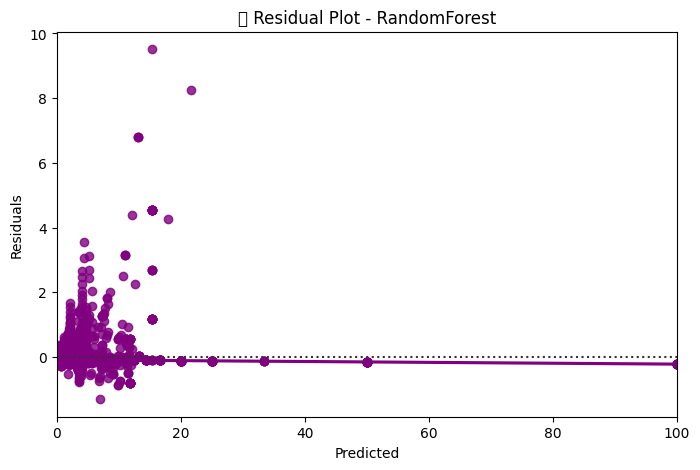

In [15]:
residuals = y_test - y_test_pred
plt.figure(figsize=(8, 5))
sns.residplot(x=y_test_pred, y=residuals, lowess=True, color='purple')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title(f"🟣 Residual Plot - {best_model_name}")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


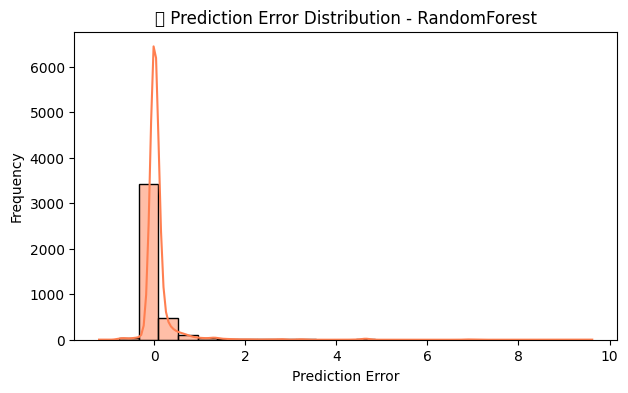

In [16]:
error = y_test - y_test_pred
plt.figure(figsize=(7, 4))
sns.histplot(error, kde=True, bins=25, color='coral')
plt.title(f"📉 Prediction Error Distribution - {best_model_name}")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


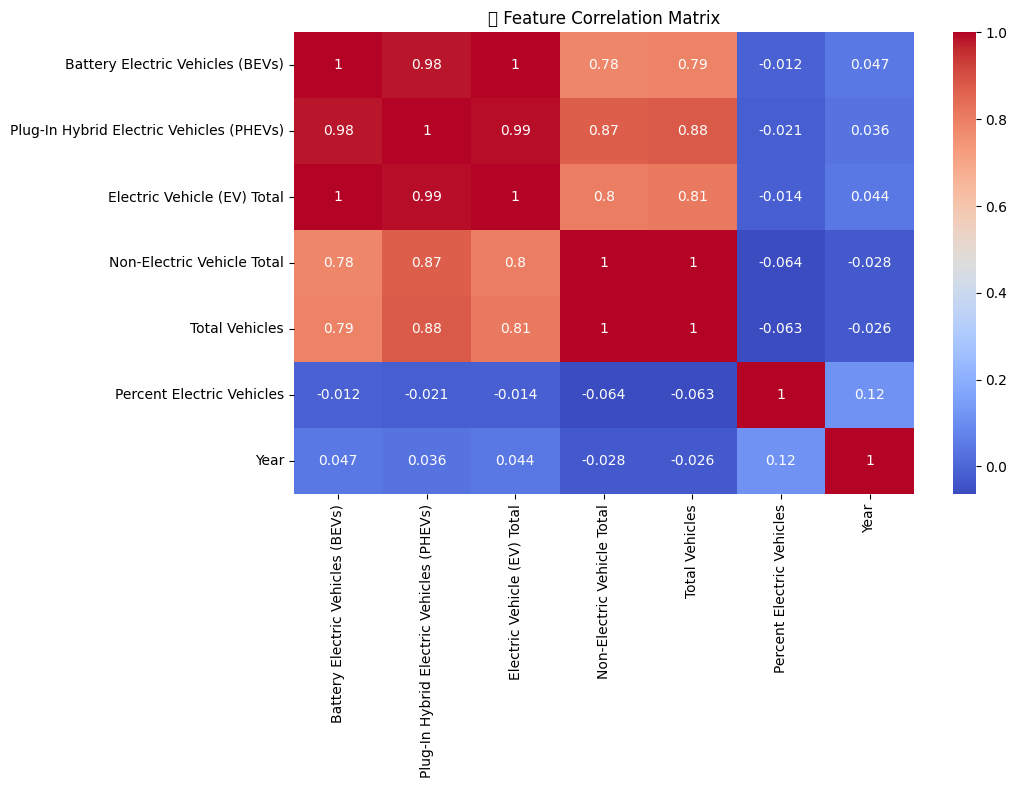

In [21]:
# Select only numeric columns for correlation matrix calculation
numeric_df = df.select_dtypes(include=np.number)

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("🔗 Feature Correlation Matrix")
plt.show()

In [22]:
future_pred = best_model.predict(future_X)
for year, val in zip([2025, 2026], future_pred):
    print(f"📈 Forecast {year}: {val:.2f}")


📈 Forecast 2025: 1.20
📈 Forecast 2026: 1.20


In [23]:
all_years = df.index.year.tolist() + [2025, 2026]
all_preds = list(best_model.predict(X)) + list(future_pred)

fig = go.Figure()
fig.add_trace(go.Scatter(x=all_years[:len(y)], y=y.tolist(), mode='lines+markers', name='Actual'))
fig.add_trace(go.Scatter(x=all_years, y=all_preds, mode='lines+markers',
                         name='Model Prediction', line=dict(dash='dash')))
fig.update_layout(title=f'📊 Forecast using {best_model_name}',
                  xaxis_title='Year', yaxis_title='Target')
fig.show()


In [24]:
print("✅ Full Model Pipeline Completed")
print(f"🏆 Best Model: {best_model_name}")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")
print("📊 Forecast for 2025 & 2026 done")
print("🧠 Feature importance, consistency matrix, and residuals analyzed")


✅ Full Model Pipeline Completed
🏆 Best Model: RandomForest
RMSE: 0.48, MAE: 0.12, R2: 1.00
📊 Forecast for 2025 & 2026 done
🧠 Feature importance, consistency matrix, and residuals analyzed
